# 10 - Discrete random variables

 We can think of a discrete probability distribution as a set, called the support, sample space, or set of outcomes together with a probability mass function which assigns a probability to each element of the support such that the sum of all outcome is one.
 
## Bernoulli Random Variables

A random variable derived via a coin flip. Coin flip may be biased, this bias is referred to as $\theta$.

When we want to say some random variable, lets say X, follows a particular distribution we write

X $\sim$ Bernoulli($\theta$)

Now lets define this in clojure:

In [9]:
(defn flip [weight]
    (if (< (rand 1) weight)
    true
    false))

(def my-var (flip 0.5))

my-var

true

Now this *my-var* is a particular random variable. We use random variable to refer to the use of a random variable.
Note that random variables can be complex, and built from many other random variable Legos (trademark)

In [70]:
(def my-vars (list (flip 0.5) (flip 0.5) (flip 0.5)))
my-vars

(true true false)

## Joint distributions

What we have done above is called a joint variable! The notation for what we have above is:

$\Pr(X^1 , X^2, X^3)$ 

## Categorical Distribution

A categorical distribution is the name for a probability distribution over k discrete outcomes. It takes as a parameter a probability vector $\vector(theta)$, of length k specifying the probabilities of the k possible outcomes. 
This is essentially a k sided weighted die.

Now lets build a sampler for categorical distributions:


In [71]:
(defn normalize [params]
  (let [sum (apply + params)]
    (map (fn [x] (/ x sum)) params)))

#'user/normalize

In [52]:
(defn sample-categorical [outcomes params]
  (if (flip (first params))
    (first outcomes)
    (sample-categorical (rest outcomes)
                        (normalize (rest params)))))
(sample-categorical
 (list 'call 'me 'Ishmael)
 (list 0.5 0.25 0.25))

call

In [48]:
(def vocabulary (list 'call 'me 'Ishmael))
(def probabilities (list (/ 1 3) (/ 1 3 ) (/ 1 3 )))

(defn score-categorical [outcome outcomes params]
  (if (empty? params)
    (throw "no matching outcome")
    (if (= outcome (first outcomes))
      (first params)
      (score-categorical outcome (rest outcomes) (rest params)))))

(score-categorical 'call vocabulary probabilities)

1/3

Note that we will often be working with very small number, especially for large corpora!
This is why we work in log probabilities to avoid underflow.

In [41]:
(defn log2 [n]
  (/ (Math/log n) (Math/log 2)))

(defn exp [x n]
  (reduce * (repeat n x)))

(defn logsumexp [& log-vals]  ;;the & turns multiple inputs into a list of input
  (let [mx (apply max log-vals)]
    (+ mx
       (log2
        (apply +
               (map (fn [z] (exp 2 z))
                    (map (fn [x] (- x mx))
                         log-vals)))))))

(logsumexp -1 -1)

0.0

# 11 - Bag of Words
Lets say we wish to model a more complex corpora with a vocabulary that is larger than simply *{a,b}*. 

Let us use the categorical distribution to model our text. This simple method is called a __Bag Of Words__ approach. This approach simplifies a language by assuming there is no dependacy between words ie. each word occurs independently of eachother.

In [ ]:
(def vocabulary (list 'call 'me 'Ishmael))
(def probabilities (list (/ 1 3) (/ 1 3 ) (/ 1 3)))

(defn sample-BOW-sentence [len]
  (if (= len 0)
    '()
    (cons (sample-categorical vocabulary probabilities)
          (sample-BOW-sentence (- len 1)))))

In [53]:
(sample-BOW-sentence 10)

(me me call Ishmael me Ishmael call Ishmael Ishmael call)

Now let us create a **scorer** for this bag of word approach

In [54]:
(defn list-foldr [f base lst]
  (if (empty? lst)
    base
    (f (first lst)
       (list-foldr f base (rest lst)))))

(defn score-BOW-sentence [sen]
  (list-foldr
   (fn [word rest-score]
     (* (score-categorical word vocabulary probabilities)
        rest-score))
   1
   sen))

(score-BOW-sentence '(call me Ishmael))

1/27

Note that in a bag of words model this is just the product of the probabilities of each word occuring.

$\Pr(W^1 , W^2, W^3 = w^1,...w^3 | \theta) = \prod_{i=1}^{3} \theta(w^i)$ 

## Evaluating BOW model

Now that we have defined a scoring model we can evaluate the probability of any data set under our bag of words model: so lets do that now!

My corpus will be a corpus composed of two sentences, while the vocabulary (alphabet in a sense) accounts for repeated words.

In [72]:
(def my-corpus
  '((Call me Ishmael)
    (Some years ago - never mind how long precisely
          - having little or no money in my purse |,|
          and nothing particular to interest me on shore
          |,| I thought I would sail about a little and
          see the watery part of the world)))

#'user/my-corpus

In [75]:
(def vocabulary
  '(Call me Ishmael Some years ago - never
         mind how long precisely -
         having little or no money in my purse |,|
         and nothing particular to interest on shore
         I thought would sail about a little see
         the watery part of the world))

#'user/vocabulary

In [76]:
(def probabilities
  (repeatedly
   (count vocabulary)
   (fn [] (/ 1 (count vocabulary)))))

probabilities

(1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44 1/44)

In [61]:
(defn score-corpus [corpus]
  (list-foldr
   (fn [sen rst]
     (* (score-BOW-sentence sen) rst))
   1
   corpus))

(score-corpus my-corpus)

1/338205875259658045183604744768328020880470782823915894885779120457486123405410304

That it, it suffices to simply know the total number of times each word was used in the corpus to calculate the probability of the corpus.
Notice how that is an increadibly small number? when working with corpuses composed of thousands of words you will run into underflow, where the number is too small to be stored in memory so it is rounded down to zero, which is useless.
This is why we work in log likelyhoods.



In [62]:
(defn score-BOW-sentence [sen]
  (list-foldr
   (fn [word rest-score]
     (+ (log2 (score-categorical word vocabulary probabilities))
        rest-score))
   0
   sen))

(defn score-corpus [corpus]
  (list-foldr
   (fn [sen rst]
     (+ (score-BOW-sentence sen) rst))
   0
   corpus))

(score-corpus my-corpus)

-267.51214931322755

Note how in logs we work with sums, as the log of a product of numbers in the sum of the logs of the individual numbers

# 12 - Inductive Inferrence

The lecture notes werent posted :<

# 13 - ML

Not all probabilistic models are created equal, and with our scorer we can now compare different models. With allthe different classes of models it can be hard to choose one. so lets define a weak model 

In [77]:
(def my-corpus '((Call me Ishmael)
                 (Call me Ishmael)
                 (Call me Ishmael)
                 (Call me Ishmael)
                 (Call me Ishmael)
                 (Call me Ishmael)
                 (Call me Ishmael)))

(def vocabulary '(Call me Ishmael Some years ago
                       - never mind how long precisely
                       - having little or no money in my purse
                       , and nothing particular to interest
                       me on shore I thought would sail about
                       a little see  the watery part of the
                       world))

(def probabilities
  (repeatedly (count vocabulary)
              (fn [] (/ 1 (count vocabulary)))))

(score-corpus my-corpus)

-113.95155984874407

In [78]:
(def vocabulary '(Call me Ishmael))

(def probabilities (repeatedly
                    (count vocabulary)
                    (fn [] (/ 1 (count vocabulary)))))

(score-corpus my-corpus)

-33.28421251514428

As we can see, this model assigns a significantly higher score to this corpus. This in fact, is much higher probability, remember that the log probability is (negative) the number of times that we must multiply 1/3 together to get the probability.

## Principle of Maximum likelihood

The principle we used above is known in statistics as the principle of maximum likelihood. This principle states that we should choose the model in our class which maximizes the likelihood of our data occuring. So if our class of models is parameterized by some vector $\vec{\theta} \in \Theta$ then the prinicple of Maximum likelihood should choose the model inex by the $\theta$ that maximized the log likelihood of the model given the data $C$, ie $L(\theta; C)$

$\theta = argmax{L(\theta; C)}$

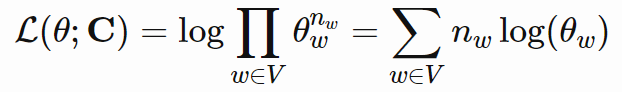

In other words, it is just the product of the probabilities of each word raised to the number of times that word appeared in the corpus. 

Which probabilities maximize this quantity? It is a bit complicated to show, but the probabilities for each word which maximize the log likelihood in the case of a BOW model:

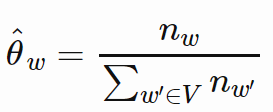

In other words, the optimal probabilities for each word under the principle of maximum likelihood are just the renormalized counts. Now we can see why our restriction of the vocabulary to just the words in the corpus gave us a higher likelihood — it was the maximum likelihood estimator.

# 14 - Smoothing

We just showed that restricting our distributions to just the words that occured in our corpus. This might be perfect for our corpus but does not **generalize** well to new data occuring in our corpus. In fact, theta would assign a probability of zero to unknown words resulting in skewed calculations. 

This is know as **overfitting** where the model is too fitted to our data and can't take in any newly occurring data! Of course our corpus must remain finite, but we must have a model that can adapt to this scenario:

## Additive smoothing

A simple way to do this is to use Laplace (additiove smoothing. To do Laplace smoothing, we add some number n (often 1) to the count of each word in our vocabulary. Sometimes these numbers are called __pseudocounts__, we can think of them as the (imaginary) number of times we have seen each word **before** we observed our corpus $C$.

Lets use a to denounce these pseudoCounts, then our smoothed maximum likelihood estimator $\vec{\theta}$ is now

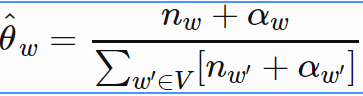

# 15 - Independence Marginalizaton & Conditioning

Not all languges can be modeled by a BOW model, as BOW models assume independence between words in our language. So lets look a little bit more into probability.

## Joint distribution 

The joint distribution over a set of random variables is one of the most fundamental concepts in probabilistic modeling and we will return to it many times.

Lets us see an example of joint distributions in our Vocabulary $V = {call, me, Ishmael}$ Lets consider strings composed of two words:

$Pr(W^1, W^2 = w^1, w^2)$

There are 9 possible strings of two, lets visualize this with a table:

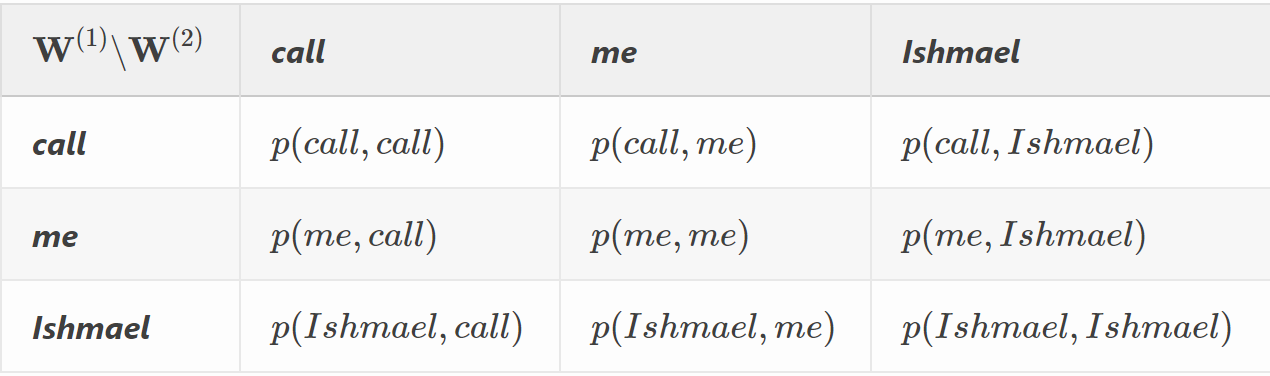

Note that joint distributions increase in complexity with larger vocabulary and the joint.

Joint Distributions can be very complex and rely on many parameters to specify completely the probabilities and information surrounding the interactions of the random variables. These models are often simplified by introducin g **independence assumptions** about the random variables. In the case of the BOW model defined above, the PMF is defined by the product of each indivdual word as we assume indepencence:

$Pr(W^1, W^2 = w^1, w^2) = Pr(w^1) \times Pr(w^2)$

BOW models are **statistically independant**

## Independance

Independence means that the value one random varianle does not affect our "belief" of the value of another random variable. Let us take our vocabulary $V = {call, me, Ishmael}$ and values $ < \frac{1}{2}, \frac{1}{4}, \frac{1}{ 4}>$ We can now fill in the table from above!

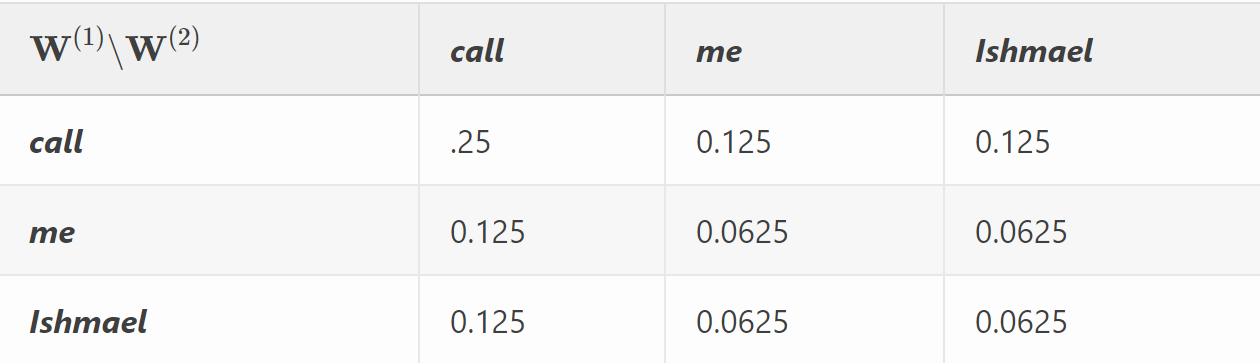

Note that in indpendence relations the order does not matter, which is why this matrix is symmetric. Now lets thing about the relationship between the joint distribution $Pr(A, B)$ and the its components (Marginal distributions) $Pr(A),Pr(B)$

## Marginal Distributions

$Pr(A, B)$ and the its components (Marginal distributions) $Pr(A),Pr(B)$ are related through marginalization, which is the process of computing the total probability of a set of outcomes for some subset of random variables, adding up all of the ways those outcomes could come about ignoring the other random variables. Lets go back o our previous exmpample, lets compute the probability of Ishmael being the second word?

There are 3 states where this can occur:
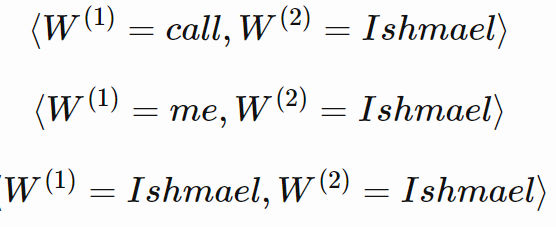

So the marginal probability of $W^2 = Ishmael$ is 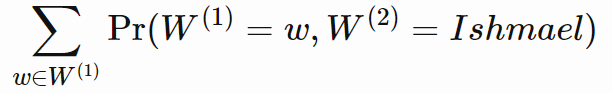

Now lets find the marginals distribution of all out variables!

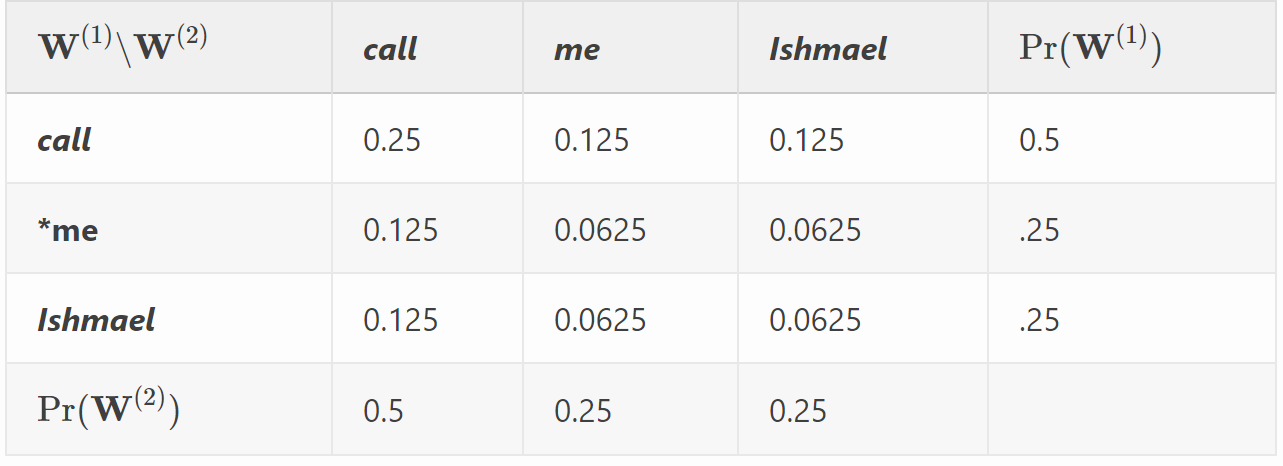

So if we have access to the joint distribution of our model and we wish to find a scorer for for ou marginal distribution we can sum over all the joints where our marginal occurs. when we sample we can just ignore the marginal distributions 

## Conditional Distribution

Conditioning can be thought of as a form of hypothetical reasoning where we ask about the probability distribution over some (set of) random variables, assuming some other random variables take on some particular values. In general, the part of the conditional distribution to the right of the conditioning bar, the conditioner can be any predicate that we require to be true.

For Descrete random Variables:

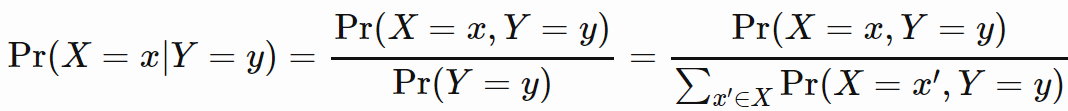

For the sample example as above its is just the Final column where w2 = ishamel, and once renormalised is the same as our marginal distribution. This is due to independence relation

Note if X&Y are independent 
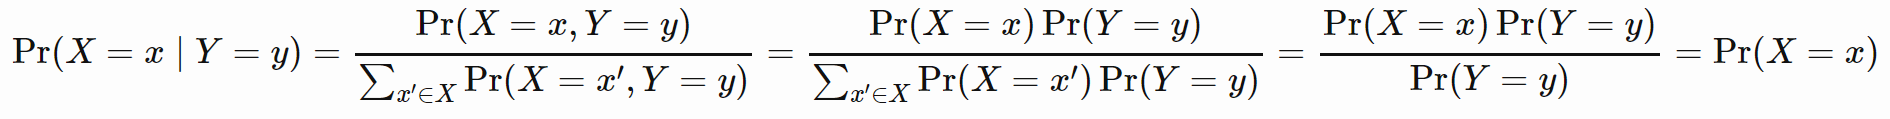

The chain rule tells us that if we pick an ordering of the random variables, say $W^1,W^2, W^3$ , we can rewrite each probability in the table above, in terms of a product of conditional probabilities that take into account the values of all random variables earlier in the sequence.

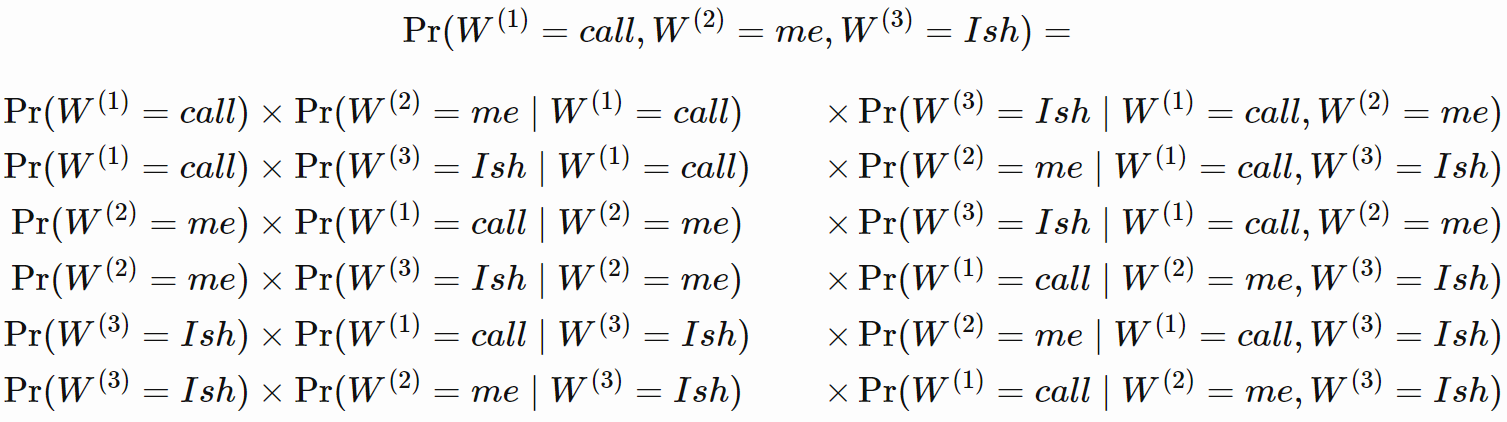

If I have a joint distribution over two variables, say a corpus **C** out of the space of possible corpora $C$ and some model parameters $\theta$ out of a space of possible model parameters $\Theta$ we can use the chain rule to write the distribution like so:

$Pr(C = c, \Theta = \theta) = Pr(C = c | \Theta = \theta)Pr(\Theta = \theta)$